# Learned Reconstruction

In inverse problems, we want to recover some signal $x$ from noisy measurements $y$ where we know the forward model $\mathcal{T} : \mathcal{X} \to \mathcal{Y}$
$$
    y = \mathcal{T}(x) + e
$$
In machine learning for inverse problems we aim to find some operator $\mathcal{T}_\theta^\dagger : \mathcal{Y} \to \mathcal{X}$ that inverts this process
$$
    \mathcal{T}_\theta^\dagger(y) \approx x
$$

This notebook demonstrates how to use ODL to perform learned reconstruction of the famous MNIST dataset. We demonstrate three ways of doing this

* Fully learned reconstruction
* Learned post-processing
* Learned iterative reconstruction

and we also compare to FBP-based reconstruction.

The results should be approximately

| Method                 |  Mean Error  |
|------------------------|----------|
| FBP                    | 0.01694  |
| Fully learned          | 0.00226  |
| FBP + learned denoiser | 0.00260  |
| Learned Iterative      | 0.005150 |

Note that the examples in this notebook may take some time to run, approximately 10-15 minutes each can be expected on a reasonable laptop.

**Note:** This is a pytorch port of [the notebook using tensorflow](part3_learned_reconstruction.ipynb) with reduced text, see the other notebook for more details.

In [1]:
!pip install torchmetrics

In [ ]:
!pip install numpy==1.26.4 --force-reinstall --no-cache-dir
import os
os.kill(os.getpid(), 9)  # 重启内核，确保降级生效


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 251.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
!pip install odl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.7/764.7 kB 36.4 MB/s eta 0:00:00


In [3]:
import odl
from odl.contrib.torch import OperatorModule

In [4]:
%matplotlib inline
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import pandas as pd  # For reading and writing CSV files
from PIL import Image
import numpy as np
import os
import csv
import time
# Custom module imports
import models.aux_funs as maf
import optimizers as op
import regularizers as reg
import utils.configuration as cf
import train
from models.ANN import FullRecoNet
from models.AutoMap import AutoMap
from models.iRadonMap import iRadonMap
# Set random seed for reproducibility
torch.manual_seed(123)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import shutil
shutil.rmtree('./data/MNIST', ignore_errors=True)


## Get training and test data

We create loaders for the MNIST data:

In [7]:
from torch.utils.data import random_split
from torchvision import datasets, transforms
import torch

# Define the desired total subset size (e.g., 600 samples)
total_subset_size = 10000  # Total samples for the subset (train + validation)
train_val_split = [8000, 2000]  # Split subset into 500 for training, 100 for validation
test_subset_size = 2000  # Define a similar subset size for the test set

# Define transformations: convert to Tensor and normalize
trafo = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),  # Normalization based on MNIST mean and std dev
])

# Load the MNIST dataset for training and validation
dset_train_val = datasets.MNIST('./data', train=True, download=True, transform=trafo)

# Step 1: Subset the original dataset to a smaller size (600 samples in total)
subset_train_val, _ = random_split(dset_train_val, [total_subset_size, len(dset_train_val) - total_subset_size])

# Step 2: Further split the smaller subset into training and validation sets
train_dataset, val_dataset = random_split(subset_train_val, train_val_split)

# Data loaders for training and validation using the smaller dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=50, shuffle=True)

# Load the MNIST dataset for testing
dset_test = datasets.MNIST('./data', train=False, transform=trafo)

# Step 3: Subset the test set
test_subset, _ = random_split(dset_test, [test_subset_size, len(dset_test) - test_subset_size])
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=50, shuffle=True)

print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_subset)}')


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.05MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.41MB/s]

Train dataset size: 8000
Validation dataset size: 2000
Test dataset size: 2000


## Create ODL objects

We initialize the ray transform on a space suitable for the MNIST images. We also create a filtered backprojection (FBP) operator for comparison, and for the FBP denoising net later on:

In [67]:
space = odl.uniform_discr([-14, -14], [14, 14], [28, 28], dtype='float32')
geometry = odl.tomo.parallel_beam_geometry(space, num_angles=72)
fwd_op = odl.tomo.RayTransform(space, geometry)
fbp_op = odl.tomo.fbp_op(fwd_op)

## Make pytorch `Module`s from ODL operators

For use in our neural networks, we create pytorch modules from the above operators. For this we use the `OperatorAsModule` class from `odl.contrib.torch`. It implements automatic differentiation as required for backpropagation in pytorch, and it supports extra batch and channel axes.

In [68]:
fwd_op_mod = OperatorModule(fwd_op)
fwd_op_adj_mod = OperatorModule(fwd_op.adjoint)
fbp_op_mod = OperatorModule(fbp_op)

## Some helper functions

For the generation of noisy projection data and for visualization of the results we use the following helpers:

In [69]:
def generate_data(images):
    """Create noisy projection data from images.

    The data is generated according to ::

        data = fwd_op(images) + noise

    where ``noise`` is standard white noise.

    Parameters
    ----------
    images : `Variable`, shape ``(B, C, 28, 28)``
        Input images for the data generation.

    Returns
    -------
    data : `Variable`, shape ``(B, C, 5, 41)``
        Projection data stack.
    """
    torch.manual_seed(123)
    data = fwd_op_mod(images)
    data += Variable(torch.randn(data.shape)).type_as(data)
    return data


def show_image_matrix(image_batches, titles=None, indices=None, **kwargs):
    """Visualize a 2D set of images arranged in a grid.

    This function shows a 2D grid of images, where the i-th column
    shows images from the i-th batch. The typical use case is to compare
    results of different approaches with the same data, or to compare
    against a ground truth.

    Parameters
    ----------
    image_batches : sequence of `Tensor` or `Variable`
        List containing batches of images that should be displayed.
        Each tensor should have the same shape after squeezing, except
        for the batch axis.
    titles : sequence of str, optional
        Titles for the colums in the plot. By default, titles are empty.
    indices : sequence of int, optional
        Object to select the subset of the images that should be shown.
        The subsets are determined by slicing along the batch axis, i.e.,
        as ``displayed = image_batch[indices]``. The default is to show
        everything.
    kwargs :
        Further keyword arguments that are passed on to the Matplotlib
        ``imshow`` function.
    """
    import matplotlib.pyplot as plt

    if indices is None:
        displayed_batches = image_batches
    else:
        displayed_batches = [batch[indices] for batch in image_batches]

    displayed_batches = [batch.data if isinstance(batch, Variable) else batch
                         for batch in displayed_batches]

    nrows = len(displayed_batches[0])
    ncols = len(displayed_batches)

    if titles is None:
        titles = [''] * ncols

    figsize = 2
    fig, rows = plt.subplots(
        nrows, ncols, sharex=True, sharey=True,
        figsize=(ncols * figsize, figsize * nrows))

    if nrows == 1:
        rows = [rows]

    for i, row in enumerate(rows):
        if ncols == 1:
            row = [row]
        for name, batch, ax in zip(titles, displayed_batches, row):
            if i == 0:
                ax.set_title(name)
            ax.imshow(batch[i].squeeze(), **kwargs)
            ax.set_axis_off()
    plt.show()

## Generate test data

We take one batch from the test dataset and generate the corresponding test projection data for validation:

In [70]:
# Get a batch of test images and generate test projection data
for i, (images, _) in enumerate(test_loader):
    if i == 1:
        break

test_images = Variable(images)
test_data = generate_data(test_images)

## FBP reconstruction

First we make a simple FBP reconstruction and compare it to the ground truth.

Average error: tensor(0.0021)


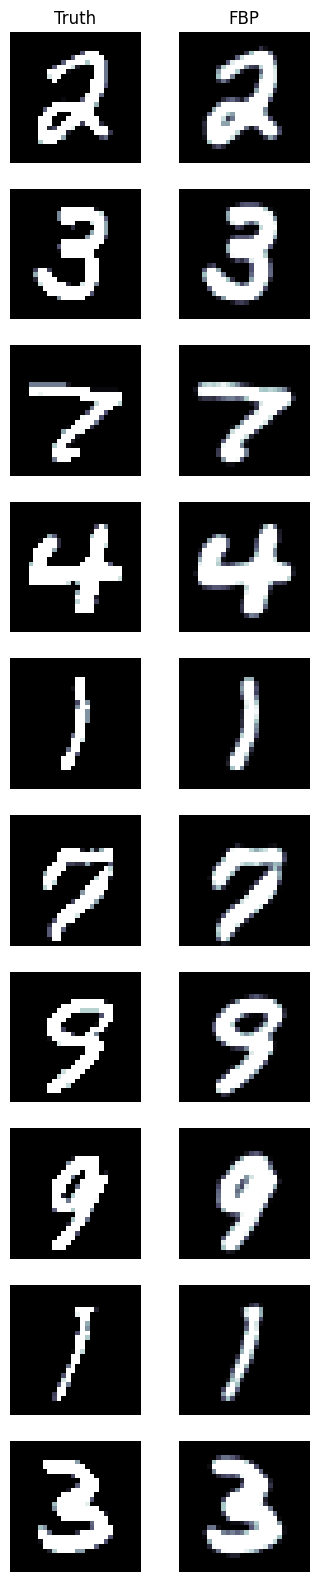

In [71]:
fbp_recos = fbp_op_mod(test_data)
print('Average error:', F.mse_loss(fbp_recos, test_images).data / len(test_images))

# Display examples
results = [test_images, fbp_recos]
titles = ['Truth', 'FBP']
show_image_matrix(results, titles, indices=slice(10, 20), clim=[0, 1], cmap='bone')

##Learned reconstruction

In [72]:
conf_args = {
    # optimizer
    'delta':1.0, 'lr':0.01, 'lamda_0':0.01, 'lamda_1':0.001, 'optim':"LinBreg", 'conv_group':True,
    'beta':0.0,
    # initialization
    'sparse_init':0.4, 'r':[5.,5., 5.],
    #training
    'epochs': 30, 'loss_train': nn.MSELoss(), 'loss_test': nn.MSELoss(),
}

conf = cf.Conf(**conf_args)


In [73]:
model = iRadonMap(input_size=72*41)


In [74]:
def init_weights(model):
    # sparsify
    maf.sparse_bias_uniform_(model, 0.1, 0.1, ltype=torch.nn.Linear)
    maf.sparse_bias_uniform_(model, 0, 0.1, ltype=torch.nn.Conv2d)
    maf.sparse_weight_normal_(model, 0.1, ltype=torch.nn.Linear)
    maf.sparsify_(model, conf.sparse_init, ltype=nn.Linear, conv_group=False)
    maf.sparse_weight_normal_(model, 0.1, ltype=torch.nn.Conv2d)
    maf.sparsify_(model, 0.4, ltype=nn.Conv2d, conv_group=conf.conv_group)
    return model

# initialize the model
model1=init_weights(model)

print('net_sparse', maf.net_sparsity(model1))

net_sparse 0.3813851220924621


In [75]:
def init_opt(conf, model):
    # -----------------------------------------------------------------------------------
    # Get access to different model parameters
    # -----------------------------------------------------------------------------------
    weights_conv = maf.get_weights_conv(model)
    weights_linear = maf.get_weights_linear(model)
    biases = maf.get_bias(model)

    # -----------------------------------------------------------------------------------
    # Initialize optimizer
    # -----------------------------------------------------------------------------------
    if conf.conv_group:
        reg2 = reg.reg_l1_l1_l2_conv(lamda0=conf.lamda_0, lamda1=conf.lamda_1)
    else:
        reg2 = reg.reg_l1(lamda=conf.lamda_0)

    if conf.optim == "SGD":
        opt = torch.optim.SGD(model.parameters(), lr=conf.lr, momentum=conf.beta, weight_decay=conf.lamda_1)
    elif conf.optim == "LinBreg":
        opt = op.LinBreg([{'params': weights_conv, 'lr' : conf.lr, 'reg' : reg2, 'momentum':conf.beta,'delta':conf.delta},
                          {'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_l1(lamda=conf.lamda_1), 'momentum':conf.beta,'delta':conf.delta},
                          {'params': biases, 'lr': conf.lr, 'momentum':conf.beta}])
    elif conf.optim == "L1SGD":
        def weight_reg(model):
            reg1 =  reg.reg_l1(lamda=conf.lamda_1)

            loss1 = reg1(model.layers2[0].weight) + reg1(model.layers2[2].weight)
            loss2 = reg2(model.layers1[0].weight) + reg2(model.layers1[3].weight)
            return loss1 + loss2

        conf.weight_reg = weight_reg

        opt = torch.optim.SGD(model.parameters(), lr=conf.lr, momentum=conf.beta)
    else:
        raise ValueError("Unknown Optimizer specified")

    # learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.7, patience=10,threshold=0.0001)

    return opt, scheduler


In [76]:
# Lists to store results for later saving
epoch_list = []
val_loss_list = []
sparsity_list = []

# Formatted directory structure
save_path = os.path.join(
    'ANN360PROJECTION',
    f"lr_{conf.lr}_l0_{conf.lamda_0}_l1_{conf.lamda_1}_{conf.optim}"
)
os.makedirs(save_path, exist_ok=True)

# File paths for storing results
net_sparsity_path = os.path.join(save_path, "net_sparsity.csv")
validation_loss_path = os.path.join(save_path, "validation_loss.csv")

def save_epoch_results(epoch, val_data, train_time):
    """
    Save validation results for each epoch to CSV files.
    """
    def write_csv(file_path, headers, row):
        file_exists = os.path.isfile(file_path)
        with open(file_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            if not file_exists:
                writer.writerow(headers)
            writer.writerow(row)

    write_csv(net_sparsity_path, ["Epoch", "Net Sparsity"], [epoch, val_data['Net Sparsity']])
    write_csv(validation_loss_path, ["Epoch", "Validation Loss"], [epoch, val_data['validation_loss']])

In [77]:
optimizer, scheduler = init_opt(conf, model1)
loss_train= conf.loss_train
loss_test= conf.loss_test
epochs = conf.epochs
def train(epoch):
    model1.train()
    train_loss = 0
    for batch_idx, (images, _) in enumerate(train_loader):
        images = Variable(images)
        projs = generate_data(images)
        optimizer.zero_grad()
        output = model1(projs)
        loss = loss_train(output, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    end_time = time.time()
    avg_train_loss = train_loss / len(train_loader)
    print(f'Train Epoch: {epoch} | Average Loss: {avg_train_loss:.6f} | Net Sparsity: {maf.net_sparsity(model1)}')

def validate(epoch):
    model1.eval()
    val_loss = 0
    with torch.no_grad():
        for val_images, _ in val_loader:
            val_images = Variable(val_images)
            val_projs = generate_data(val_images)
            output = model1(val_projs)
            loss = loss_train(output, val_images)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Validation Epoch: {epoch} | Learning Rate: {current_lr:.6f} | Average Loss: {avg_val_loss:.6f}')
    return avg_val_loss

# Main training loop
for epoch in range(1, epochs + 1):
    train_time = train(epoch)
    avg_val_loss = validate(epoch)

    val_data = {
        'Net Sparsity': maf.net_sparsity(model1),
        'validation_loss': avg_val_loss
    }
    save_epoch_results(epoch, val_data, train_time)

    if scheduler is not None:
        scheduler.step(avg_val_loss)


Train Epoch: 1 | Average Loss: 0.996192 | Net Sparsity: 0.38130217884374096
Validation Epoch: 1 | Learning Rate: 0.010000 | Average Loss: 0.990571
Train Epoch: 2 | Average Loss: 0.994215 | Net Sparsity: 0.3799434176237815
Validation Epoch: 2 | Learning Rate: 0.010000 | Average Loss: 0.986697
Train Epoch: 3 | Average Loss: 0.892920 | Net Sparsity: 0.40385067802335683
Validation Epoch: 3 | Learning Rate: 0.010000 | Average Loss: 0.644419
Train Epoch: 4 | Average Loss: 0.559162 | Net Sparsity: 0.43750904835440596
Validation Epoch: 4 | Learning Rate: 0.010000 | Average Loss: 0.443062
Train Epoch: 5 | Average Loss: 0.367684 | Net Sparsity: 0.45870331049126534
Validation Epoch: 5 | Learning Rate: 0.010000 | Average Loss: 0.308913
Train Epoch: 6 | Average Loss: 0.278070 | Net Sparsity: 0.4708658068719236
Validation Epoch: 6 | Learning Rate: 0.010000 | Average Loss: 0.248642
Train Epoch: 7 | Average Loss: 0.231346 | Net Sparsity: 0.47999559646752243
Validation Epoch: 7 | Learning Rate: 0.01000

Plotting metrics for: LR=0.01, L0=0.01, L1=0.0, OPT=L1SGD
Plotting metrics for: LR=0.01, L0=0.01, L1=0.1, OPT=L1SGD
Plotting metrics for: LR=0.01, L0=0.01, L1=0.1, OPT=LinBreg
Plotting metrics for: LR=0.01, L0=0.01, L1=0.0, OPT=L1SGD
Plotting metrics for: LR=0.01, L0=0.01, L1=0.1, OPT=L1SGD
Plotting metrics for: LR=0.01, L0=0.01, L1=0.1, OPT=LinBreg


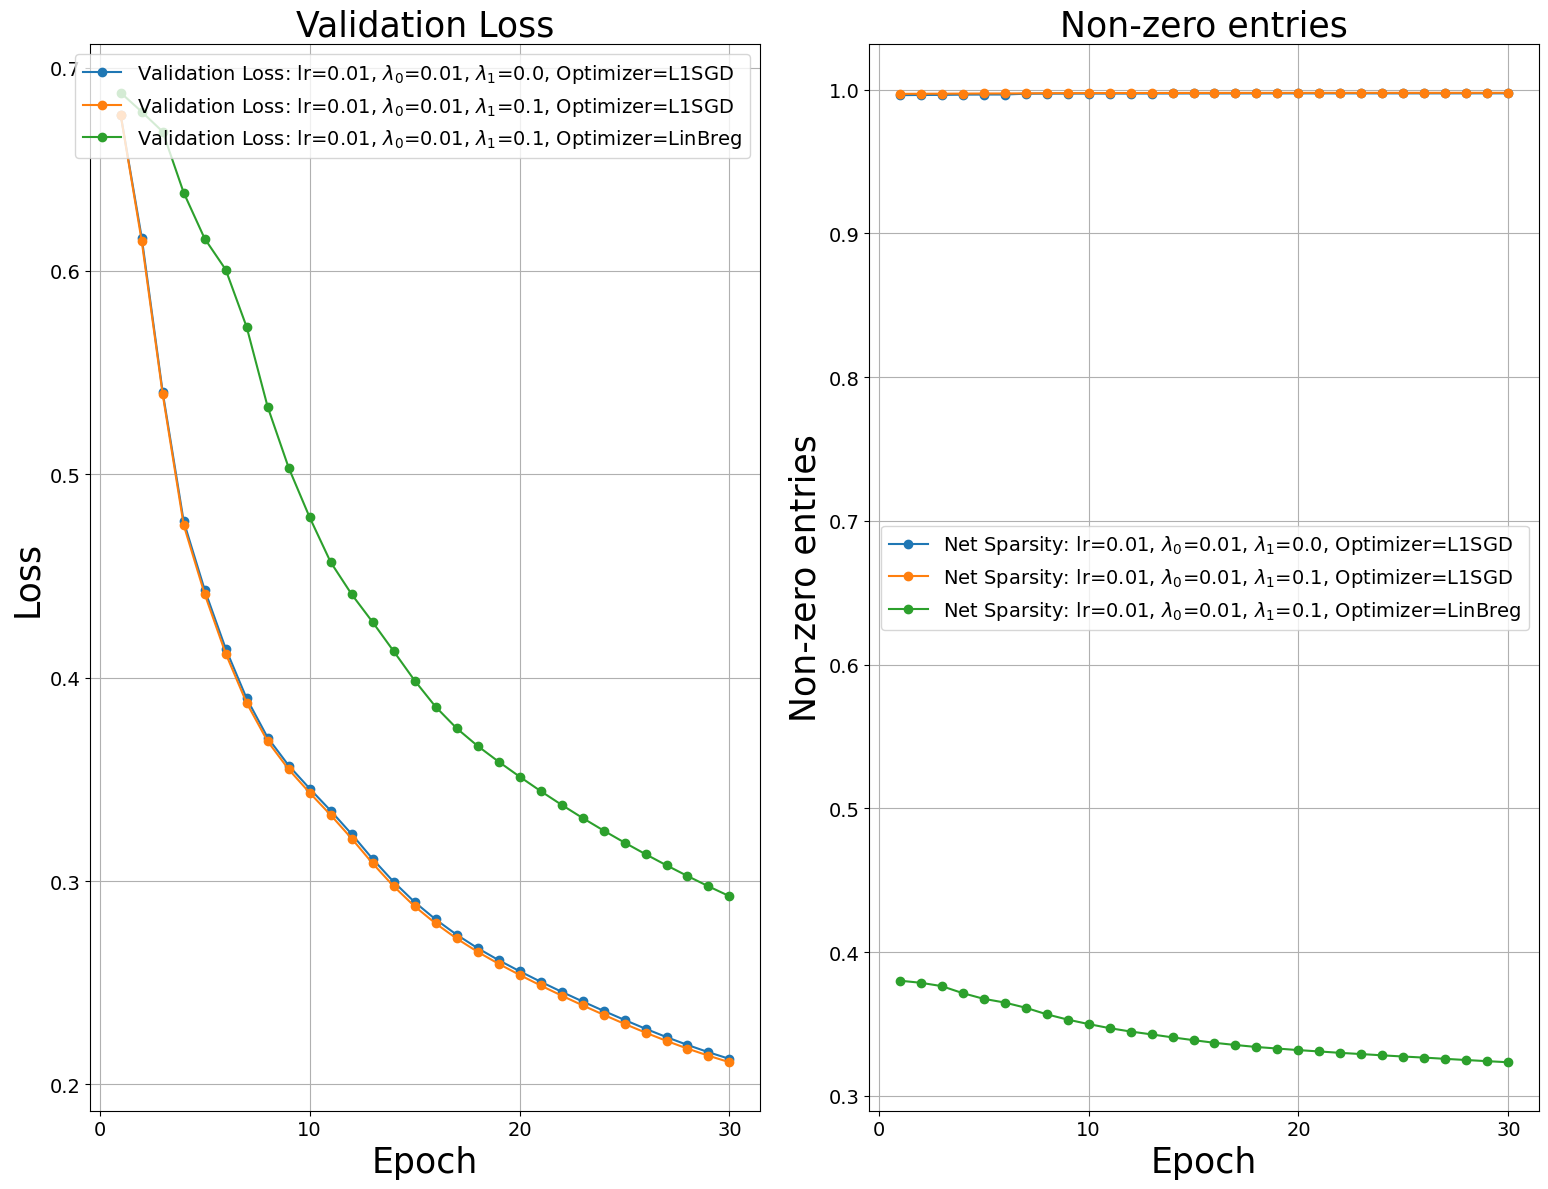

In [ ]:
import matplotlib.pyplot as plt
import os
import csv

# Function to read CSV file into a dictionary
def read_csv_to_dict(file_path):
    data = {}
    with open(file_path, mode='r') as file:
        reader = csv.reader(file)
        headers = next(reader)
        for row in reader:
            epoch = int(row[0])
            value = float(row[1])
            data[epoch] = value
    return data

# Function to read node sparsity CSV file into a dictionary
def read_node_sparsity_csv(file_path):
    data = {}
    with open(file_path, mode='r') as file:
        reader = csv.reader(file)
        headers = next(reader)
        node_indices = [header.split('_')[-1] for header in headers[1:]]  # Extract node indices from headers
        for row in reader:
            epoch = int(row[0])
            values = list(map(float, row[1:]))
            for idx, node_index in enumerate(node_indices):
                if node_index not in data:
                    data[node_index] = []
                data[node_index].append(values[idx])
    return data

# Function to plot training loss
def plot_training_loss(ax, save_path, formatted_lr, formatted_lamda0, formatted_lamda1, formatted_opt):
    loss_path = os.path.join(save_path, "validation_loss.csv")
    loss_data = read_csv_to_dict(loss_path)

    epochs = list(loss_data.keys())
    loss_values = list(loss_data.values())

    ax.plot(epochs, loss_values, marker='o', linestyle='-', label=f'Validation Loss: lr={formatted_lr}, $\\lambda_0$={formatted_lamda0}, $\\lambda_1$={formatted_lamda1}, Optimizer={formatted_opt}')
    ax.tick_params(axis='both', labelsize=14)
    return epochs

# Function to plot net sparsity
def plot_net_sparsity(ax, save_path, formatted_lr, formatted_lamda0, formatted_lamda1, formatted_opt):
    net_path = os.path.join(save_path, "net_sparsity.csv")
    net_data = read_csv_to_dict(net_path)

    epochs = list(net_data.keys())
    net_values = list(net_data.values())

    ax.plot(epochs, net_values, marker='o', linestyle='-', label=f'Net Sparsity: lr={formatted_lr}, $\\lambda_0$={formatted_lamda0}, $\\lambda_1$={formatted_lamda1}, Optimizer={formatted_opt}')
    ax.tick_params(axis='both', labelsize=14)
    return epochs

# Function to create and display plots in a 2x2 grid
def create_and_display_plots_1x2(base_path):
    fig, axs = plt.subplots(1, 2, figsize=(16, 12))
    axs = axs.flatten()
    plot_functions = [plot_training_loss, plot_net_sparsity]
    titles = ['Validation Loss', 'Non-zero entries']
    ylabels = ['Loss', 'Non-zero entries']

    subdirectories = [name for name in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, name))]

    for ax, plot_function, title, ylabel in zip(axs, plot_functions, titles, ylabels):
        all_epochs = []
        for subdir in subdirectories:
            subdir_path = os.path.join(base_path, subdir)

            # Parse the directory name to extract parameters
            params = subdir.split('_')
            formatted_lr = params[1]
            formatted_lamda0 = params[3]
            formatted_lamda1 = params[5]
            formatted_opt = params[6]

            print(f"Plotting metrics for: LR={formatted_lr}, L0={formatted_lamda0}, L1={formatted_lamda1}, OPT={formatted_opt}")

            epochs = plot_function(ax, subdir_path, formatted_lr, formatted_lamda0, formatted_lamda1, formatted_opt)
            all_epochs.extend(epochs)

        ax.set_title(title, fontsize=25)
        ax.set_ylabel(ylabel, fontsize=25)
        ax.set_xlabel('Epoch', fontsize=25)
        ax.legend(fontsize=14)
        ax.grid(True)

        if all_epochs:
            max_epoch = max(all_epochs)
            ax.set_xticks(range(0, max_epoch + 1, 10))  # Set x-axis ticks for every 10 epochs
            ax.set_xticklabels(range(0, max_epoch + 1, 10))  # Set x-axis tick labels for every 10 epochs

    plt.tight_layout()
    plt.savefig('Training_Result/Figure/Figure4')
    plt.show()

# Example usage
save_path = 'Training_Result/Figure/Figure4'
create_and_display_plots_1x2(save_path)


Visualizing a sample from the results in comparison to FBP:

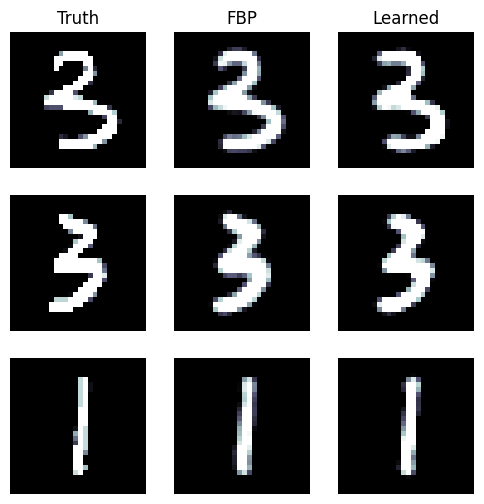

net_sparse 0.4752793578866178


In [52]:
test_res_full = model1(test_data)
results = [test_images.cpu(), fbp_recos.cpu(), test_res_full.cpu()]
titles = ['Truth', 'FBP', 'Learned']
show_image_matrix(results, titles, indices=slice(20, 23), clim=[0, 1], cmap='bone')
print('net_sparse', maf.net_sparsity(model1))
output_folder = '/content/ANN360PROJECTION'
output_path = os.path.join(output_folder, 'image_matrix.png')
plt.tight_layout()
plt.savefig(output_path)
plt.close()

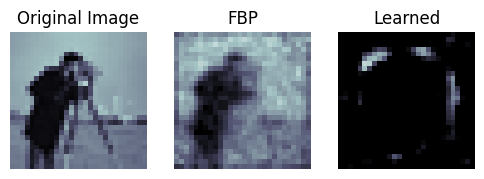

In [78]:
# Step 1: Load and preprocess the image
img_path = 'cameraman.jpg'
img = Image.open(img_path).convert('L')  # Convert to grayscale
# # Resize to 28x28
img = img.resize((28, 28))

# Normalize and create a tensor
img_tensor = torch.tensor(
    np.array(img, dtype=np.float32)/255.0  # Normalize to [0, 1]
).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions (1, 1, 28, 28)

img_variable = Variable(img_tensor)

# Step 2: Generate projection data
projection_data = generate_data(img_variable)  # Shape: (1, 1, 5, 41)

# Step 3: Feed the projection data into the model
fbp_reconstruction = fbp_op_mod(projection_data)  # FBP reconstruction
model1_result = model1(projection_data)  # Model1 reconstruction
# Step 4: Visualize the results
results = [
    img_tensor.squeeze(0).cpu(),  # Original image
    fbp_reconstruction.squeeze(0).cpu(),  # FBP result
    model1_result.squeeze(0).cpu()  # Model1 result
]
titles = ['Original Image', 'FBP', 'Learned']

show_image_matrix(results, titles=titles, clim=[0, 1], cmap='bone')
output_folder = '/content/ANN360PROJECTION'
output_path = os.path.join(output_folder, 'cameraman.png')
plt.tight_layout()
plt.savefig(output_path)
plt.close()


These examples look much better than FBP (unsurprisingly), but there are still some issues with noise, deformations etc.

To also make an assessment about the number of trainable parameters and thus the scalability of the approach (the more parameters, the harder to train), the total number of parameters in the model can be checked like this:

In [ ]:
print('Total number of parameters:',
      sum(param.numel() for param in model1.parameters()))
print('Training data size:', 600 * 28 ** 2)

Total number of parameters: 2064144
Training data size: 470400


It turns out that for this tiny problem, the number of parameters is over 2 million. This is still a good deal away from the input data size (47 million), but overfitting is likely with this network. Therefore we explore sparser architectures.